## Task II

In this task we will aim to classify images from the CIFAR-10 dataset using convolutional neural networks, CNNs. 

In the first code cell, we import all necessary Python libaries and modules for our image classification task.

## Libraries

In [1819]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset

- Snakke om hvilke bibliotek vi bruker og hvorfor (pytorch)
- fordeler og ulemper med dem
- Hvilke alternativ vi hadde å velge mellom

In this code cell ew prepare the dataset and apply preprocessing steps.

Transformations:    
    
transforms.ToTensor- Converts the PIL images to PyTorch tensors and scales pixel values to [0, 1].    

transforms.Normalize- Normalizes each RGB channel to have a mean of 0 and a standard deviation of 1.This helps stabilize and speed up training.

Dataset Loading:        

torchvision.datasets.CIFAR10- oads the CIFAR-10 dataset. We load it twice: once for training and once for testing.

Classes:    

Defines the 10 class labels in CIFAR-10, which are used for interpretation and visualization later on.

## Loading and Normalizing the data 

In [1820]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

training_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


- Introdusere normalisering og hvorfor vi bruker denne normaliseringen (Burde vi endre den?) finn formellen for å komme fram til normaliseringen
- Introdusere CIFAR-10 datasettet
- Snakke om treningsdata og testdata til CIFAR-10 datasettet

## Visualisation of the data

In this code cell, we inspect the shape of a single image from the training dataset.    

Since we have applied transforms.ToTensor() earlier, the image is now a tensor with shape (3, 32, 32):

    3: RGB channels
    32 x 32: Image height and width 

This confirms that each image in CIFAR-10 is a 32×32 color image.

In [1821]:
# Shape of image
img, label = training_data[0]
img.size()

torch.Size([3, 32, 32])

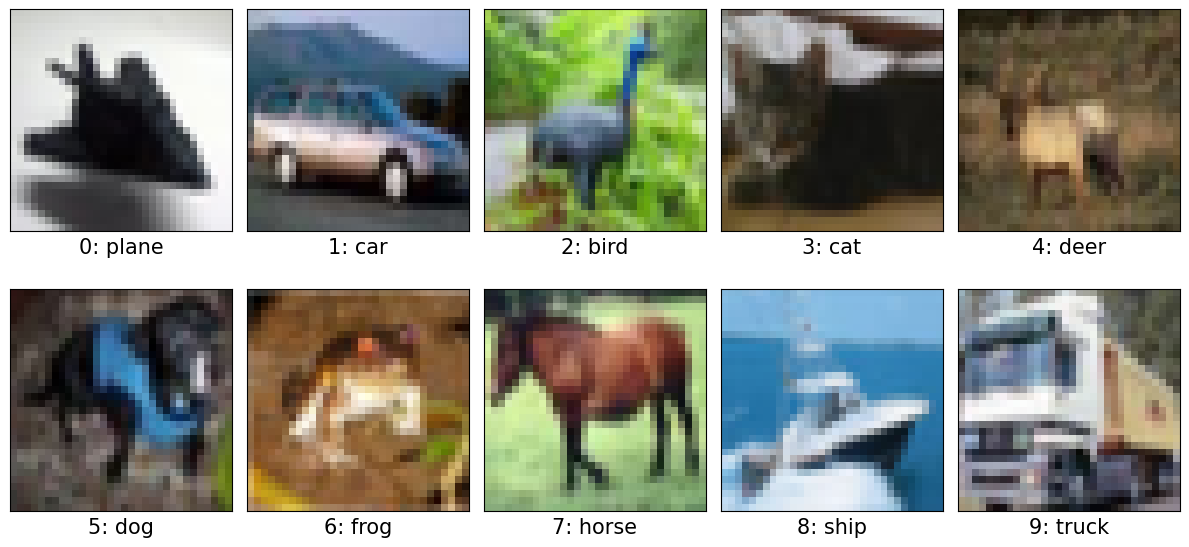

In [1822]:
# Visualize one training image per class
sample_images = [training_data.data[np.asarray(training_data.targets) == label][0] for label in range(10)]

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, axis in enumerate(axes.flat):
    axis.set_xlabel(f"{i}: {classes[i]}", fontsize=15)
    axis.imshow(sample_images[i])
    axis.set_xticks([])
    axis.set_yticks([])  

plt.tight_layout()
plt.show()


In this code cell, we visualize one sample image for each class.    

sample_images- filter out the images by their class label (using `np.asarray(training_data.targets) == label`) and select the first image for each class.   

plt.subplots(2, 5, figsize=(12, 6))- Creates a grid of 2 rows and 5 columns to display the images. This gives us space to display 10 images, one for each class.    

Loop over axes.flat- For each image:    
    axis.set_xlabel(...)- Adds a label for each image with its corresponding class name.    

    axis.imshow(...)- Displays the image in the current axis.   

    axis.set_xticks([]) and axis.set_yticks([])- Removes the axis ticks for better visualization.   

This gives us a visual overview of what the images in each class look like.

- Vi skal lage en binærklassifiserer for frosker
- Vet ikke helt hva vi kan snakke om her?

In [1823]:
def print_stats(dataset, class_names):
    from torch.utils.data import Subset

    label_counts = {}

    if isinstance(dataset, Subset):
        targets = dataset.dataset
        indices = dataset.indices
    else:
        targets = dataset
        indices = range(len(dataset))

    for i in indices:
        _, label = targets[i]
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

    print(f"Total images: {len(indices)}")
    for label in sorted(label_counts):
        print(f"Label {label} ({class_names[label]}): {label_counts[label]}")


This code cell defines a helper function called "print_starts()" to explore the distribution of labels in a dataset.    
It calculates and prints the number of images for each class. And it works with both full datasets and subsets.

This is useful for checking if your dataset is balanced, which can affect how well your model performs across different classes.

- Funksjon for å gi infromasjon om et gitt datasett
- Denne blir brukt bare for å få ett overblikk av dataen før og etter vi endrer den
- Denne kan også senere å bli gjort om til å lage grafer til dataen (men vet ikke om det er nødvendig)
- "Bør endre den"

In [1824]:
print("Traning data")
print_stats(training_data, classes)
print("\n")
print("Test data")
print_stats(test_data, classes)

Traning data
Total images: 50000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 5000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


Test data
Total images: 10000
Label 0 (plane): 1000
Label 1 (car): 1000
Label 2 (bird): 1000
Label 3 (cat): 1000
Label 4 (deer): 1000
Label 5 (dog): 1000
Label 6 (frog): 1000
Label 7 (horse): 1000
Label 8 (ship): 1000
Label 9 (truck): 1000


- Dette blir nok snakket om når vi presenterer dataen
- Men det er sikkert noe å snakke om her 

## Building the Traningdataset

This code cell defines a custom dataset class FrogBinaryDataset that converts the CIFAR-10 dataset into a binary classification problem. The goal is to classify if the image is a frog, or not a frog.

In [1825]:
class FrogBinaryDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset 

    def __getitem__(self, idx):
        data, label = self.subset[idx]
        # Convert to binary: 1 if frog (label 6), else 0
        if label == 6:
            binary_label = 1
        else:
            binary_label = 0
        return data, binary_label

    def __len__(self):
        return len(self.subset)

- Dette er en klasse som tar inn ett data sett og gjør "labels" om til binære verdier
- Det er sikkert en bedre måte å gjøre dette på (jeg fant det i dokumentasjon), men det funker :)
- Forklare hvorfor vi gjør dette og hva fordelen med å gjøre dette er

In [1826]:
print("Traning data")
print_stats(training_data, classes)

Traning data
Total images: 50000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 5000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


- Tidligere hadde jeg splittet dataen sånn at det var 50% frosker og 50% en lik fordeling av alle andre klassene, men det gjorde at jeg fikk veldig dårlige resultater under validering så jeg endret det tilbake til dette. Men vi må spørre om det er en annen måte vi kan splitte denne treningsdataen.
- Kan vi endre på forskebildene slik at vi får flere froskebilder å trene på, evt hvordan?

In [1827]:
# Convert to binary values 1 for frogs and o for other classes
binary_trainset = FrogBinaryDataset(training_data)

# Put into dataloader
trainloader = DataLoader(binary_trainset, batch_size=64, shuffle=True)

- Gjør om til binære verdier
- Putter det i en DataLoader for lettere bruk

## Building the Test and Validationdataset

In [1828]:
# Calculate lengths for the split
total_size = len(test_data)
split_size = int(total_size // 2)

test_subset = Subset(test_data, range(split_size))
val_subset = Subset(test_data, range(split_size, total_size))


- Her også hadde jeg tidligere en annen fordeling på dataen, men nå har jeg bare delt testdataen 50/50
- Spør smeinar leder om hvordan vi bør splitte dataen

In [1829]:
print("Testdata")
print_stats(test_subset, classes)
print("\n")
print("Validationdata")
print_stats(val_subset, classes)

Testdata
Total images: 5000
Label 0 (plane): 488
Label 1 (car): 505
Label 2 (bird): 512
Label 3 (cat): 497
Label 4 (deer): 507
Label 5 (dog): 488
Label 6 (frog): 491
Label 7 (horse): 495
Label 8 (ship): 504
Label 9 (truck): 513


Validationdata
Total images: 5000
Label 0 (plane): 512
Label 1 (car): 495
Label 2 (bird): 488
Label 3 (cat): 503
Label 4 (deer): 493
Label 5 (dog): 512
Label 6 (frog): 509
Label 7 (horse): 505
Label 8 (ship): 496
Label 9 (truck): 487


In [1830]:
# Convert to binary values 1 for frogs and 0 for other classes
binary_testset = FrogBinaryDataset(test_subset)
binary_validationset = FrogBinaryDataset(val_subset)

In [1831]:
# Wrap in DataLoaders
testloader = DataLoader(binary_testset, batch_size=64, shuffle=True)
valloader = DataLoader(binary_validationset, batch_size=64, shuffle=True)

## Convolutional Neural Network

In [1832]:
class FrogClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv_layer1 = nn.Conv2d(3, 12, kernel_size=5)

        self.bn1 = nn.BatchNorm2d(12)
        
        self.pool = nn.MaxPool2d(2, 2)                      
        
        self.conv_layer2 = nn.Conv2d(12, 24, kernel_size=5) 
        self.bn2 = nn.BatchNorm2d(24)
        
        # Fully connected layers
        self.fully_connected1 = nn.Linear(24 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.dropout1_fc = nn.Dropout(p=0.2)
        
        self.fully_connected2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.dropout2_fc = nn.Dropout(p=0.2)  
        
        self.fully_connected3 = nn.Linear(84, 2)

    def forward(self, data):
        data = self.pool(F.relu(self.bn1(self.conv_layer1(data))))
        data = self.pool(F.relu(self.bn2(self.conv_layer2(data))))
        
        data = torch.flatten(data, 1)
        
        data = F.relu(self.bn3(self.fully_connected1(data)))
        data = self.dropout1_fc(data)
        
        data = F.relu(self.bn4(self.fully_connected2(data)))
        data = self.dropout2_fc(data)
        
        data = self.fully_connected3(data)
        
        return data


This code cell defines a custom convolutional neural network (CNN) architecture for the frog vs notfrog binary classification task. 

Convolutional Layers:   
    conv_layer1- 3 input channels (RGB), 12 output channels, kernel size 5×5.

    bn1- Batch normalization to stabilize and accelerate training.

    pool- Max pooling (2×2) reduces spatial dimensions.

    conv_layer2- Takes 12 input channels → 24 output channels.

    bn2- Batch normalization after second convolution.

Fully Connected Layers:
    fully_connected1- Flattens and maps the feature maps to 120 neurons.

    bn3- Batch normalization for the first FC layer.

    dropout1_fc- Dropout to reduce overfitting.

    fully_connected2- 120 to 84 units.

    bn4 and dropout2_fc- Batch norm + dropout again.

    fully_connected3- Final output layer with 2 units (for binary classification: frog or not-frog).


- Her er det veldig mye å snakke om
- Hvorfor vi har brukt batch normalisering
- Hvorfor vi valgte denne arkitekturen
- Hvorfor vi brukte relu som activation function osv 

In [1833]:
# defining an optimizer and lossfucntion
neural_network = FrogClassifier()
loss_function = nn.CrossEntropyLoss()
optimizer = SGD(neural_network.parameters(), lr=0.001, momentum=0.9)


- Hvorfor vi bruker CrossEntropy og SGD
- Fordeler med det

## Traning The Model

This code cell performs training and validation over 20 epochs, tracking performance after each pass through the data.      

This setup allows us to monitor how the model is learning over time and whether it might be overfitting

In [1834]:
list_of_train_loss = []
list_of_val_loss = []
epochs = range(20)

for epoch in epochs:
    print(f"\nEpoch {epoch} / {max(epochs)}")
    
    # Traning 
    neural_network.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        optimizer.zero_grad()
        outputs = neural_network(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    avg_train_loss = running_loss / len(trainloader)
    list_of_train_loss.append(avg_train_loss)
    print(f"Train Loss: {avg_train_loss:.4f}")

    neural_network.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    # Validation
    with torch.no_grad():
        for val_inputs, val_labels in valloader:
            outputs = neural_network(val_inputs)
            loss = loss_function(outputs, val_labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    
    avg_val_loss = val_loss / len(valloader)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    list_of_val_loss.append(avg_val_loss)




Epoch 0 / 19
Train Loss: 0.2462
Validation Loss: 0.2085

Epoch 1 / 19
Train Loss: 0.1895
Validation Loss: 0.1699

Epoch 2 / 19
Train Loss: 0.1690
Validation Loss: 0.1541

Epoch 3 / 19
Train Loss: 0.1579
Validation Loss: 0.1490

Epoch 4 / 19
Train Loss: 0.1469
Validation Loss: 0.1475

Epoch 5 / 19
Train Loss: 0.1394
Validation Loss: 0.2123

Epoch 6 / 19
Train Loss: 0.1307
Validation Loss: 0.1442

Epoch 7 / 19
Train Loss: 0.1272
Validation Loss: 0.1346

Epoch 8 / 19
Train Loss: 0.1215
Validation Loss: 0.1450

Epoch 9 / 19
Train Loss: 0.1158
Validation Loss: 0.1460

Epoch 10 / 19
Train Loss: 0.1094
Validation Loss: 0.1551

Epoch 11 / 19
Train Loss: 0.1054
Validation Loss: 0.1601

Epoch 12 / 19
Train Loss: 0.1033
Validation Loss: 0.1406

Epoch 13 / 19
Train Loss: 0.0953
Validation Loss: 0.1518

Epoch 14 / 19
Train Loss: 0.0935
Validation Loss: 0.1413

Epoch 15 / 19
Train Loss: 0.0890
Validation Loss: 0.1798

Epoch 16 / 19
Train Loss: 0.0854
Validation Loss: 0.1552

Epoch 17 / 19
Train Los

This code cell plots how the model’s loss changes over the 20 training epochs for both training and validation sets. 

These two lines help us track how well the model is learning and whether it’s generalizing:
    list_of_train_loss- Average training loss per epoch.    
    list_of_val_loss- Average training loss per epoch.


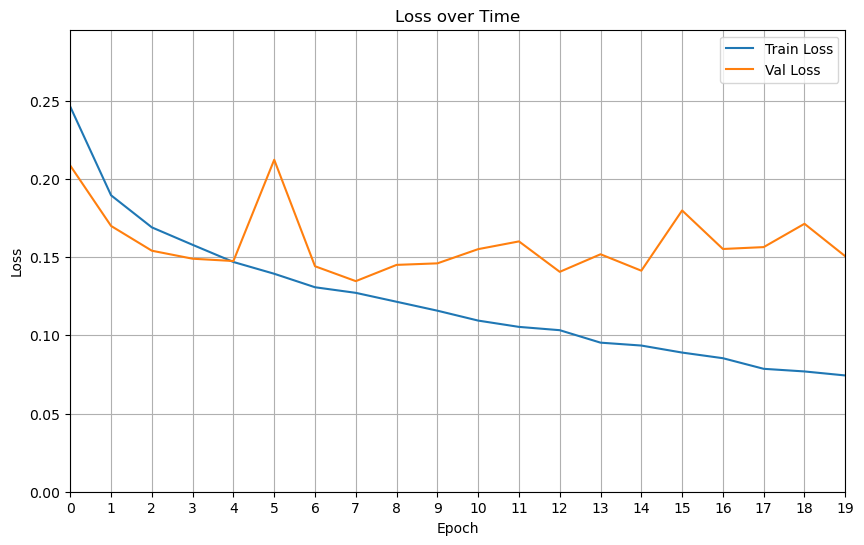

In [1835]:
# Plotting
fig, graph = plt.subplots(figsize=(10, 6))

# Plot average losses per epoch
graph.plot(list(epochs), list_of_train_loss, label='Train Loss', color='tab:blue')
graph.plot(list(epochs), list_of_val_loss, label='Val Loss', color='tab:orange')

# Axis limits and labels
graph.set_ylim(0, max(list_of_val_loss + list_of_train_loss) * 1.2)
graph.set_xlim(min(epochs), max(epochs))
graph.set_xticks(epochs) 
graph.legend()
plt.title("Loss over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


- Jeg vet ikke helt hva som skjer med validation loss. Har prøvd å endre loss rate, endre på dataen, osv. Jeg antar at det er fordi validerings dataen er for spars og at den ikke får generalisere, men idk. 
- Treningen ser bra ut da
- Har seminarleder noen tips :)

In [1836]:
# Save the model
PATH = './cifar_net.pth'
torch.save(neural_network.state_dict(), PATH)

## Evaluation

In [1837]:
network = neural_network
network.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [1838]:
# set model to eval mode
neural_network.eval()

FrogClassifier(
  (conv_layer1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected1): Linear(in_features=600, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1_fc): Dropout(p=0.2, inplace=False)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_fc): Dropout(p=0.2, inplace=False)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)

This code cell evaluates the trained model on the validation dataset using two key metrics: accuracy and recall, specifically for detecting frogs.  

Accuracy:   
    -The percentage of total predictions that were correct. 
    -Gives a general idea of how well the model performs overall.   

Recall:
    -Measures how well the model identifies actual frogs.   
    -Important when missing a positive case (frog) is more costly than a false alarm.


These metrics help us better understand how the model performs, especially in imbalanced or binary classification settings. High accuracy doesn't always mean good performance on the class of interest. That's why recall is crucial here.

In [1839]:
correct = 0
recall = 0
total = 0

true_positive = 0
false_negative = 0

with torch.no_grad():
    for val_inputs, val_labels in valloader:
        outputs = neural_network(val_inputs)
        loss = loss_function(outputs, val_labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

        # For recall calculation (frog = 1)
        true_positive += ((predicted == 1) & (val_labels == 1)).sum().item()
        false_negative += ((predicted == 0) & (val_labels == 1)).sum().item()

val_accuracy = 100 * correct / total
recall = true_positive / (true_positive + false_negative + 1e-8)  

print(f"Accuracy: {val_accuracy:.2f}% | Recall (frog): {recall:.4f}")


Accuracy: 93.94% | Recall (frog): 0.7800


## Prdiction on New image

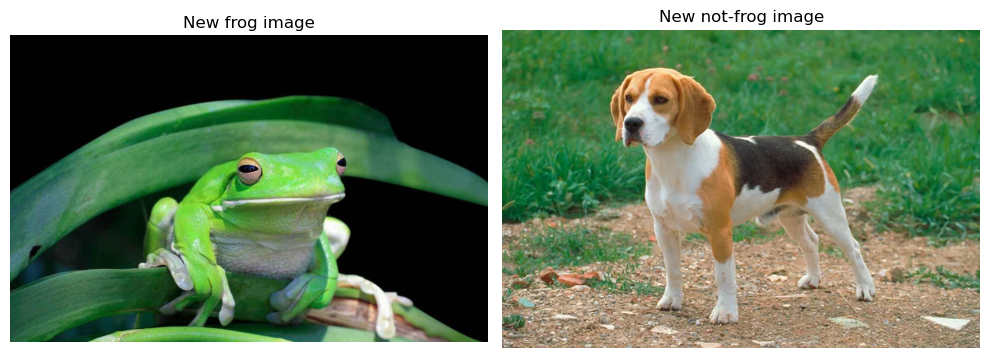

In [1840]:
# Present new image
frog_image = Image.open("/Users/stefannaess/Documents/GitHub/INFO284_SemesterOppgave_2025V/Oppgave2/new_frog_picture.jpg")
not_frog_image = Image.open("/Users/stefannaess/Documents/GitHub/INFO284_SemesterOppgave_2025V/Oppgave2/new_dog_picture.jpg")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(frog_image)
axes[0].set_title("New frog image")
axes[0].axis("off")


axes[1].imshow(not_frog_image)
axes[1].set_title("New not-frog image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [1841]:
# Transforms

# Transform for changing the image into a 32x32 and normalizing
new_transform = transforms.Compose([
    transforms.Resize((32, 32)),            
    transforms.ToTensor(),                 
    transforms.Normalize((0.5, 0.5, 0.5),     
                         (0.5, 0.5, 0.5))
])

# Unnormalize for display
unnormalize = transforms.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std=[2.0, 2.0, 2.0]
)

In [1842]:
# Present image to be processed

# Apply transform
transformed_frog_image = new_transform(frog_image)
transformed_not_frog_image = new_transform(not_frog_image)


transformed_frog_image = unnormalize(transformed_frog_image)
transformed_not_frog_image = unnormalize(transformed_not_frog_image)

# Convert to (H, W, C) and clip for valid pixel range
display_image_forg = transformed_frog_image.permute(1, 2, 0).numpy()
display_image_not_forg = transformed_not_frog_image.permute(1, 2, 0).numpy()

# Clip intervals outside of normalisation range
display_image_forg = np.clip(display_image_forg, 0, 1)
display_image_not_forg = np.clip(display_image_not_forg, 0, 1)

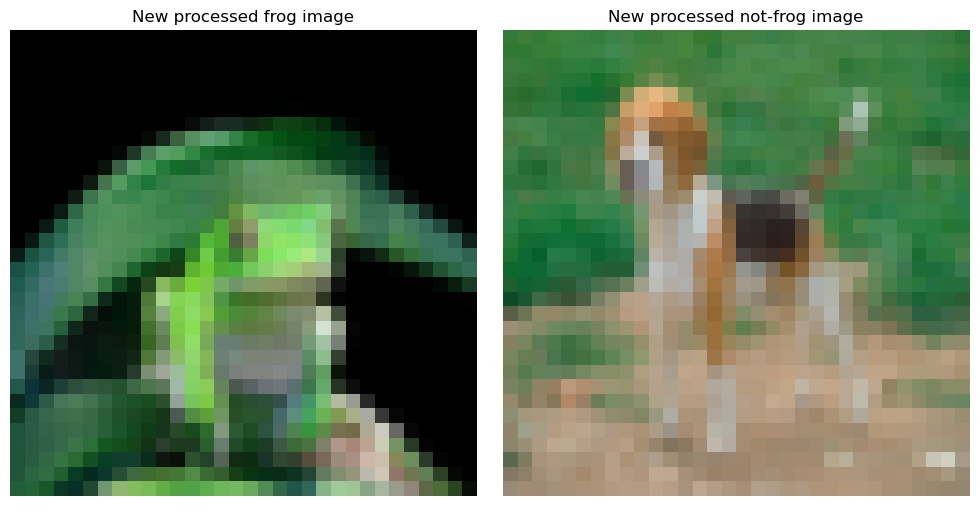

In [1843]:
# Display preprocessed images

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(display_image_forg)
axes[0].set_title("New processed frog image")
axes[0].axis("off")


axes[1].imshow(display_image_not_forg)
axes[1].set_title("New processed not-frog image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [1844]:
# Load in model
model = FrogClassifier()
model.load_state_dict(torch.load("./cifar_net.pth"))
model.eval()

FrogClassifier(
  (conv_layer1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected1): Linear(in_features=600, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1_fc): Dropout(p=0.2, inplace=False)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_fc): Dropout(p=0.2, inplace=False)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)

In [1845]:
images = [frog_image, not_frog_image]
# Predicted labels
labels = []

# Make prediction
for img in images:
    # Preprocess image
    processed_img = new_transform(img).unsqueeze(0)
    
    with torch.no_grad():
        
        output = model(processed_img)

        # Prediction
        prediction = torch.argmax(output, dim=1).item()

        # Confidence
        probability = torch.softmax(output, dim=1)
        confidence = probability[0][prediction].item()

        label = f"{'Frog' if prediction == 1 else 'Not Frog'} ({confidence:.2%})"
        labels.append(label)


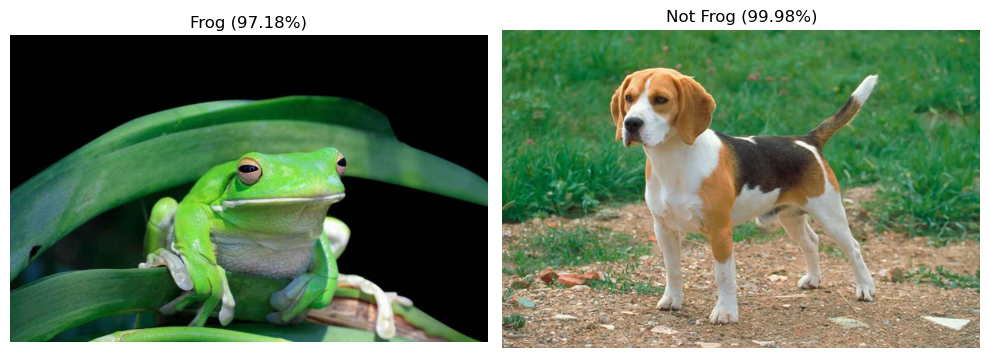

In [1846]:
# Create plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display images
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(labels[i], fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

Our model achieves approximately 98.91 % accuracy on the test set. While this is a solid result, we can potentially improve further using deeper architectures, better regularization, or improved optimizers.

CNNs works well for image classification. But you need to be careful preprocessing and normalization are crucial. The performance can vary significantly across different classes, often due to visual similarities.